# Deblending

## Load Modules and Data

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import pickle

import galcheat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from madness_deblender.deblender import Deblender, compute_residual
from madness_deblender.extraction import extract_cutouts
from madness_deblender.utils import get_data_dir_path

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
survey_name = "LSST"

Here we will load 4 fields that were simulated with the blending toolkit. These files are availble in the data folder.\
The configuration here had a maximum 20 galaxies in each field.

In [ ]:
save_file_name = os.path.join(get_data_dir_path(), "example_blend.pkl")
with open(save_file_name, "rb") as pickle_file:
    blend = pickle.load(pickle_file)
max_number = (
    20  # max number of galaxies in the 4 fields (This was set during the simulations)
)

## Visualize data

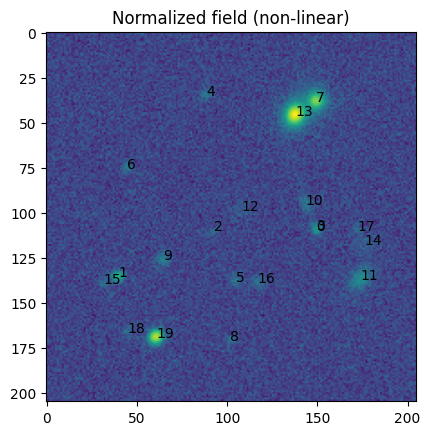

In [ ]:
# print("input_image")
band_num = 2
field_example_to_display = 0
im1 = plt.imshow(
    np.arcsinh(blend.blend_images[field_example_to_display, band_num] / 1000)
)
for i in range(len(blend.catalog_list[field_example_to_display])):
    plt.text(
        blend.catalog_list[field_example_to_display]["x_peak"][i],
        blend.catalog_list[field_example_to_display]["y_peak"][i],
        str(i),
    )
plt.title("Normalized field (non-linear)");

## Initialize the Deblender

MADNESS expects 3 sets of weights corresponding to the VAE, NF, and VAE-deblender.
There 3 weights are stored in folders named as 'vae', 'flow', and 'deblender' in the same directory and can be loaded by simply passing the base path at the time of initialization

In [ ]:
tf.get_logger().setLevel("ERROR")

weights_path = os.path.join(
    get_data_dir_path(), survey_name
)  # replace with correct path
survey = galcheat.get_survey(survey_name)
deb = Deblender(weights_path=weights_path, survey=survey)

field = blend.blend_images

## Run MADNESS

In [ ]:
# Convergence and optimizer

linear_norm_coeff = 10000  # linear normalization coefficient

# Stopping criteria
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    rtol=0.05,
    min_num_steps=40,
    window_size=15,
)

# Initial learning rate
initial_lr = 0.025
if survey_name == "LSST":
    initial_lr = 0.05

# Learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=30,
    decay_rate=0.8,
    staircase=True,
)

# Optimizer for the minimization
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

In [ ]:
# Detected positions in the format required for input
detected_positions = np.zeros((len(blend.catalog_list), max_number, 2))
num_components = []
for field_num in range(len(blend.catalog_list)):
    for gal_num in range(len(blend.catalog_list[field_num])):
        detected_positions[field_num][gal_num][0] = blend.catalog_list[field_num][
            "y_peak"
        ][gal_num]
        detected_positions[field_num][gal_num][1] = blend.catalog_list[field_num][
            "x_peak"
        ][gal_num]
    num_components.append(len(blend.catalog_list[field_num]))

In [ ]:
# Running the MAP minimization
deb(
    blended_fields=blend.blend_images,
    detected_positions=detected_positions,
    num_components=num_components,
    linear_norm_coeff=linear_norm_coeff,
    max_iter=200,
    convergence_criterion=convergence_criterion,
    optimizer=optimizer,
    use_debvader=True,
)

use debvader: True

Using encoder for initial point
Time taken for initialization: 0.5724897384643555

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 200
Number of fields: 4
Number of Galaxies: [20 14 12 16]
Dimensions of latent space: 16
--- Gradient descent complete ---
Time taken for gradient descent: 78.31803441047668


## Evaluate Results 

### Plot the log prior + log likelihood

Text(0, 0.5, 'loss')

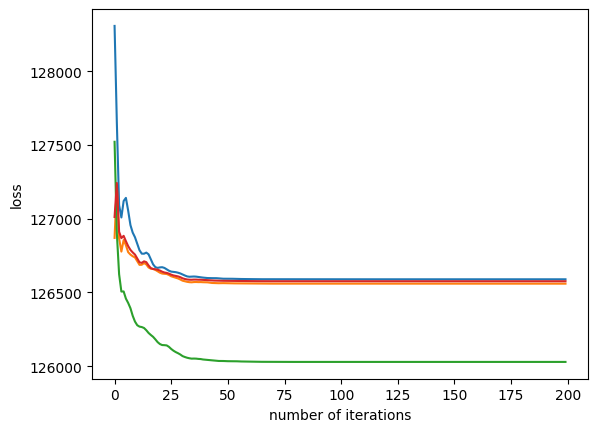

In [ ]:
plt.plot(deb.results)
plt.xlabel("number of iterations")
plt.ylabel("loss")

### See individual reconstructions

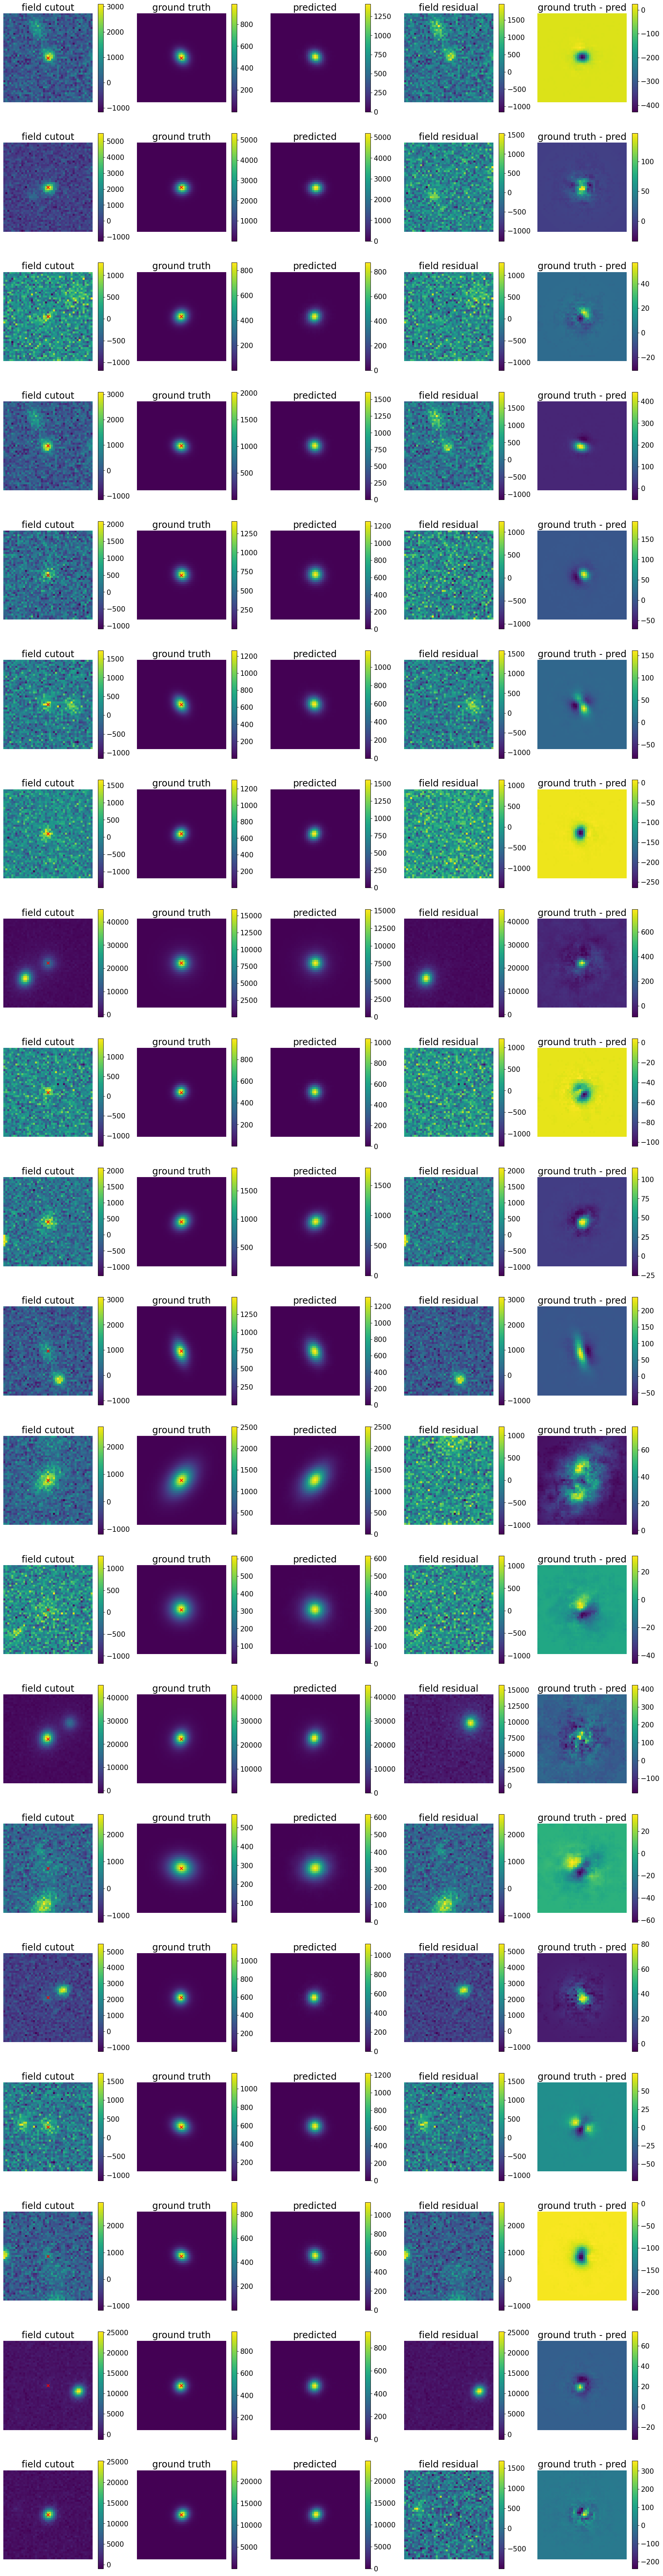

In [ ]:
fig, ax = plt.subplots(
    len(blend.catalog_list[field_example_to_display]),
    5,
    figsize=(5 * 5, 5 * len(blend.catalog_list[0])),
)

for i in range(len(blend.catalog_list[field_example_to_display])):

    field_cutout_r_band = extract_cutouts(
        blend.blend_images[field_example_to_display],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        channel_last=False,
        cutout_size=45,
    )[0][0, :, :, 2]
    galaxy_cutout_r_band = extract_cutouts(
        blend.isolated_images[field_example_to_display][i],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        cutout_size=45,
    )[0][0, :, :, 2]

    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis("off")

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis("off")

    im2 = ax[i, 2].imshow(deb.components[field_example_to_display][i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis("off")

    im3 = ax[i, 3].imshow(
        field_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis("off")

    im3 = ax[i, 4].imshow(
        galaxy_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis("off")

plt.show()

### Plot residuals

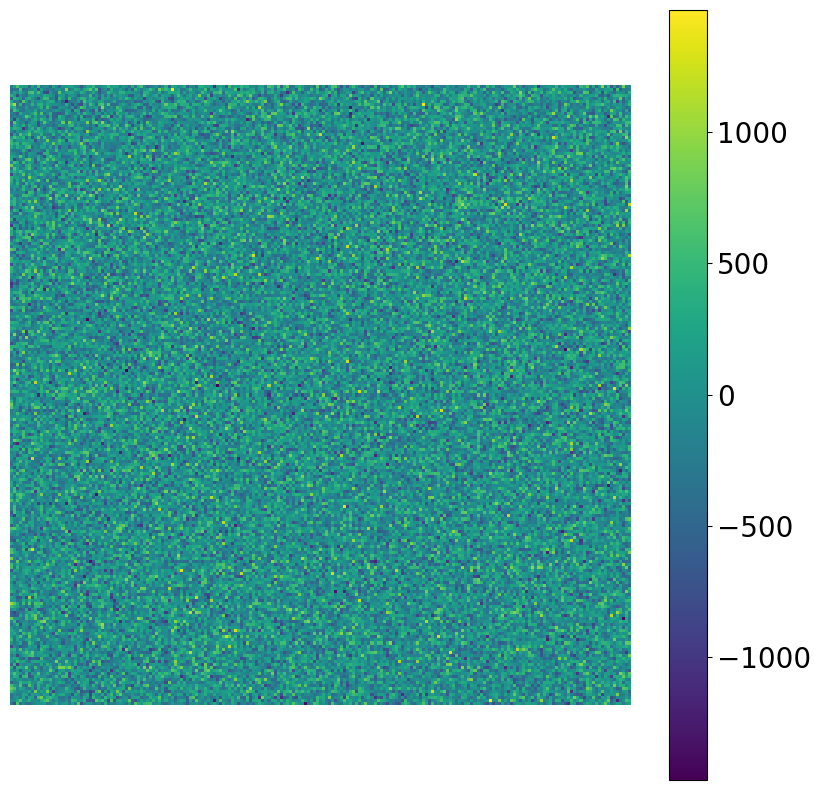

In [ ]:
# Residual after MADNESS run

fig = plt.figure(figsize=(10, 10))

ax = fig.gca()
tf.config.run_functions_eagerly(True)

tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
index_pos_to_sub = deb.get_index_pos_to_sub()
residual = compute_residual(
    blended_field=np.transpose(
        blend.blend_images[field_example_to_display], axes=[1, 2, 0]
    ),
    reconstructions=deb.components[field_example_to_display],
    index_pos_to_sub=index_pos_to_sub[field_example_to_display],
    num_components=num_components[field_example_to_display],
).numpy()
# residual = np.transpose(deb.postage_stamp,
im1 = ax.imshow(residual[:, :, 2])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off");

# for i in range(len(blend['blend_list'][0])):
# plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

### Final Reconstructed Field

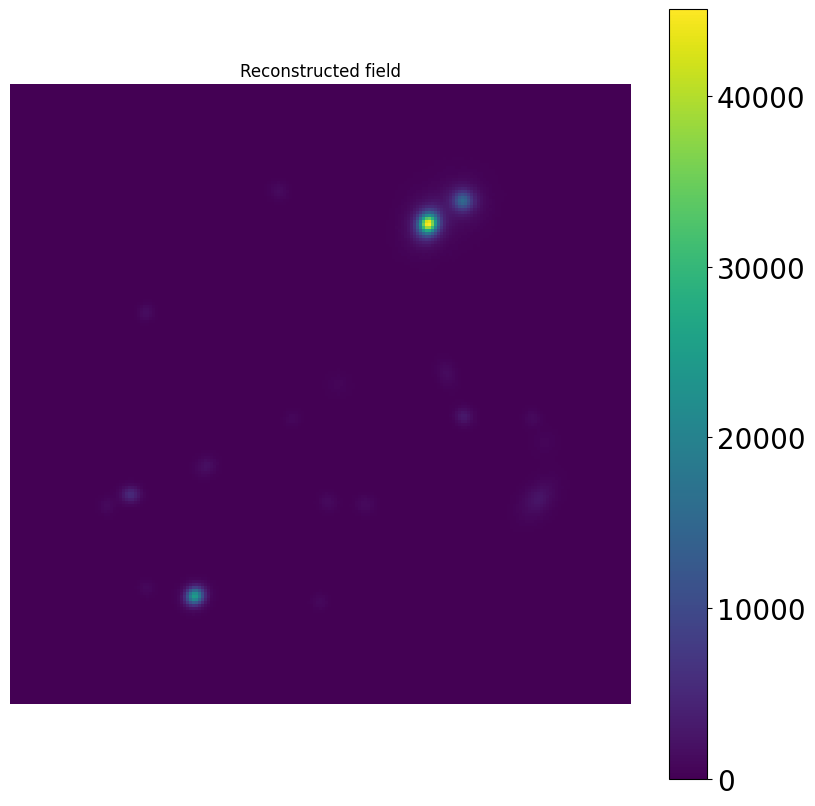

In [ ]:
predicted_field = blend.blend_images[field_example_to_display] - np.transpose(
    residual, axes=[2, 0, 1]
)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[2, :, :])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.title("Reconstructed field")
plt.axis("off")
plt.show();